<img src="https://cdn3.dualshockers.com/wp-content/uploads/2015/11/Tom-Clancys-Rainbow-Six-Siege.jpg" alt="Drawing" style="width: 700px;"/>
<center>
<h1 style="font-size:36px;">Analyzing Rainbow Six Siege</h1>
<h4>
Charles Liu, Jules Iglesia</h4>
<hr>
<h1>Introduction</h1>
</center>
<body><p>
Rainbow Six Siege (R6S) is a MMORTG (Massively Multiplayer Online Real Time Strategy) first-person shooter game developed by Ubisoft. Released in December 2015, Siege only recently gained popularity and boasts 2.3 million players daily with over 25 million registered users. The premise of the game is simple: each game consists of two teams of 5 players, with one team labeled as the Attackers and one as the Defenders. Attackers are assigned a goal depending on the game mode, which ranges from extracting a hostage from a building or planting/detonating a bomb in a building. Each game consists of best of 5 or 7 rounds, with each round ending if the Attackers objective is completed within a timeframe, time runs out, or all members of one side are eliminated. Players currently can choose from 68 maps, 36 unique operators, and what loadouts (primary weapon, secondary weapon, etc.) to use. *Full details can be found <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/index.aspx">here</a>. 
<p>
On June 27, 2017, a Game Intelligence Analyst on the Ubisoft R6S Development Team released datasets covering various metrics from in-game data. Along with this <a href="https://rainbow6.ubisoft.com/siege/en-us/news/152-293696-16/introduction-to-the-data-peek-velvet-shell-statistics">data release</a>, he revealed that analysts at Ubisoft work with several different teams and play an important role in the overall development of the game. Given the interesting statistics they were able to find, the Development Team decided to release some in-game data as a way to allow members of the community to conduct some of their own data analyses.
<p> 
In this tutorial, our goal is to tidy the in-game data given to us, provide valuable insight into which operators/loadouts are the most successful in terms of win rate/kill-death ratio, and predict these win/kill-death ratios when a certain character and loadout are chosen in different situations. For readers unfamiliar with this game, we hope this analyses will make them interested in trying out Rainbow Six Siege and provide some evidence on which operators are best to pick starting out as a new player. For experienced players, we hope to show interesting unknown statistics and maybe even give them new things to try when they play. 
<hr>
<center><h1>Getting Started with the Data</h1></center>
<body><p>
We make use of Python 3 along with a few imported libraries: pandas, numpy, matplotlib, scikit-learn, seaborn, and more. 
</body>


In [14]:
# Necessary libraries and imports to complete this tutorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

<body>
The two datasets we will be using are found at the bottom of the <a href="https://rainbow6.ubisoft.com/siege/en-us/news/152-293696-16/introduction-to-the-data-peek-velvet-shell-statistics">data release</a> mentioned earlier (Operator Loadouts Data and Objectives Data). Each dataset comes in the form of a CSV (Comma Separated Value) file.
<h2>Preprocessing the Data</h2>
<p>
Before running the code to read in the Objectives file, we had to preprocess the data using Excel and any text editor. The Objectives dataset was huge, so to have a more manageably sized dataframe we grabbed approximately the first million lines and verified the platform was PC for each entry. Additionally, when we tried to initially read in the downloaded Objectives CSV, pandas raised errors and had issues with the 'ñ' character present in every row in the "gamemode" column, so we changed every instance of 'ñ' to '.' with a text editor. On the other hand, the Operators dataset was fine.
<p>
You could do this yourself, but we have already gone ahead and modified it for you. The ZIP file for both datasets can be found <a href="https://github.com/jiglesia3/jiglesia3.github.io/blob/master/datasets.zip">here</a>. Now we read in both CSV files using Pandas, with the ';' separator.
</body>

<h2> Reading the Data </h2>

In [15]:
operators = pd.read_csv("S5_operators.csv", sep=';')
objectives = pd.read_csv("S5_objectives.csv", sep=';')
operators.head()

,platform,dateid,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,CLAYMORE,6,6,6,8
1,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,STUN GRENADE,4,2,6,8
2,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,CLAYMORE,37,40,49,70
3,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,STUN GRENADE,17,24,31,41
4,PC,20170210,Bronze,Attacker,G.E.O.-JACKAL,C7E,ITA12S,BREACH CHARGE,74,123,127,174


In the above Operators dataset, there are 12 columns. We have: 

* Platform  (PC, PS4, or Xbox One) 
* Dateid
* <a href = "http://rainbowsix.wikia.com/wiki/Ranked">Skill Rank</a> (Copper, Bronze, Silver, Gold, Platinum, Diamond)
* Role (Attacker or Defender)
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/operators.aspx">Operator</a> (unique character chosen by players at the start of each round)
* <a href="http://rainbowsix.wikia.com/wiki/Category:Weapons_of_Tom_Clancy%27s_Rainbow_Six_Siege">Weapon Loadout</a> (primary, secondary, gadget)
* Number of wins, kills, deaths, picks
   
The titles of each column should be self explanatory. If you'd like to learn more about a column in the context of the game, important topics have links to additional information.

In [16]:
objectives.head()

,platform,dateid,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,G.E.O.-JACKAL,0,0,1,1
1,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GIGN-MONTAGNE,1,0,2,3
2,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GSG9-IQ,0,0,1,1
3,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,JTF2-BUCK,0,0,1,1
4,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,SAS-THATCHER,0,0,1,1


In the above Objectives dataset, there are 12 columns. We have: 

* Platform  (PC, PS4, or Xbox One) 
* Dateid
* <a href = "https://rainbow6.ubisoft.com/siege/en-us/game-info/game-mode.aspx">Gamemode</a> (for PvP: Hostage, Secure Area, Bomb) 
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/maps.aspx">Map Name</a>
* Objective location (for Defenders to protect)
* <a href = "http://rainbowsix.wikia.com/wiki/Ranked">Skill Rank</a> (Copper, Bronze, Silver, Gold, Platinum, Diamond)
* Role (Attacker or Defender)
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/operators.aspx">Operator</a> (unique character chosen by players at the start of each round)
* Number of wins, kills, deaths, picks
   
The titles of each column should be self explanatory. If you'd like to learn more about a column in the context of the game, important topics have links to additional information.

<h2> Tidying and Modifying the Data </h2>
<p>
As PC players, we we want to only look at data with PC (no PS4 or Xbox One) as the platform. We have manually already done this with the Objectives dataset, now we just have to filter through the Operators dataset. Once that's been done, we will remove the platform column because all our data only involves the PC platform. 
<p>
We will remove the 'primaryweapon', 'secondaryweapon', and 'secondarygadget' columns because it's a little too complicated for the purpose of this tutorial. Doing this will allow us to collapse the dataframe and sum up the number of wins ('nbwins'), number of kills ('nbkills'), number of deaths ('nbdeaths'), and number of picks('nbpicks') for each respective operator. Also just wanted to note that there is a default character in the game, which is seen in the dataset as "RESERVE." There are multiple types of default characters that have different stats and loadouts, as denoted by the prefix.
<p>
The kill-death and win ratios aren't calculated for us, so we will also need to add these two columns to each dataframe. In the context of this game, kill-death and win ratios are more significant because both show averages per game as opposed to just the total number of kills or deaths. We will calculate both using two simple formulas:
<p>
k/d ratio = $\frac{nbkills}{nbdeaths}$
<p>
win ratio = $\frac{nbwins}{nbpicks}$


In [17]:
# Only PC platform rows, then deleting platform, primaryweapon, secondaryweapon, and gadget columns
operators = operators.loc[operators['platform'] == ('PC')]
del operators['platform']
del operators['primaryweapon']
del operators['secondaryweapon']
del operators['secondarygadget']

# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each operator
operators_overall = operators.groupby(['role', 'operator'], as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding k/d and win ratio columns
operators_overall['k/d_ratio'] = pd.to_numeric(operators_overall['nbkills']) / pd.to_numeric(operators_overall['nbdeaths'])
operators_overall['win_ratio'] = pd.to_numeric(operators_overall['nbwins']) / pd.to_numeric(operators_overall['nbpicks'])
operators_overall.head()

,role,operator,nbwins,nbkills,nbdeaths,nbpicks,k/d_ratio,win_ratio
0,Attacker,BOPE-CAPITAO,65205,89647,101216,138254,0.885700,0.471632
1,Attacker,G.E.O.-JACKAL,193793,304650,291541,405461,1.044965,0.477957
2,Attacker,GIGN-MONTAGNE,98517,81475,155090,216753,0.525340,0.454513
3,Attacker,GIGN-RESERVE,2558,2941,4469,5954,0.658089,0.429627
4,Attacker,GIGN-TWITCH,227325,328186,317090,469867,1.034993,0.483807


<body>
Moving on to modifying the Objectives dataframe, we will start with noticing that all types under the "gamemode" column are preceded by 'PvP . '. All rows in the data are PvP anyway, so we will remove this prefix. As proof, here's a small code snippet to show all different gamemodes currently contained in the objectives dataframe.
</body>

In [18]:
print(objectives['gamemode'].unique())

['PvP . BOMB' 'PvP . HOSTAGE' 'PvP . SECURE AREA']


We can remove the 'PvP . ' prefix using Pandas.Series.replace as shown below. 

In [19]:
# Grabbing all values under the column gamemode
gamemodes = objectives['gamemode']

# Using replace to remove the prefix
gamemodes.replace(to_replace='PvP . ', value='', regex=True, inplace=True)
objectives['gamemode'] = gamemodes
print(objectives['gamemode'].unique())

['BOMB' 'HOSTAGE' 'SECURE AREA']


Now we will do something similar to the Objectives dataframe as done to the Operators dataframe: remove the 'primaryweapon', 'secondaryweapon', and 'secondarygadget' columns, and add both the Kill-death and win ratio columns.

In [20]:
# Deleting platform column
del objectives['platform']

# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each operator, gamemode, and  map
objectives_overall = objectives.groupby(['gamemode', 'mapname', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding k/d and win ratio columns
objectives_overall['k/d_ratio'] = pd.to_numeric(objectives_overall['nbkills']) / pd.to_numeric(objectives_overall['nbdeaths'])
objectives_overall['win_ratio'] = pd.to_numeric(objectives_overall['nbwins']) / pd.to_numeric(objectives_overall['nbpicks'])
objectives_overall.head()

,gamemode,mapname,role,operator,nbwins,nbkills,nbdeaths,nbpicks,k/d_ratio,win_ratio
0,BOMB,BANK,Attacker,BOPE-CAPITAO,742,1053,1181,1609,0.891617,0.461156
1,BOMB,BANK,Attacker,G.E.O.-JACKAL,2506,4153,3828,5400,1.084901,0.464074
2,BOMB,BANK,Attacker,GIGN-MONTAGNE,1161,979,1909,2651,0.512834,0.437948
3,BOMB,BANK,Attacker,GIGN-RESERVE,15,15,35,45,0.428571,0.333333
4,BOMB,BANK,Attacker,GIGN-TWITCH,2444,3813,3682,5334,1.035578,0.458193


Perfect! Now that we've set up and simplified our data, it's time to investigate and perform analysis on the two datasets we have. 

<center>
<h3>Map: Chalet</h3>
<img src="https://ubistatic19-a.akamaihd.net/resource/en-us/game/rainbow6/siege/r6-game-info-map-chalet-01_227824.jpg" alt="Drawing" style="width: 700px;"/>
</center>

<hr>
<center><h1>Exploratory Data Analysis</h1></center>

# Talk about why we want to graph this HERE

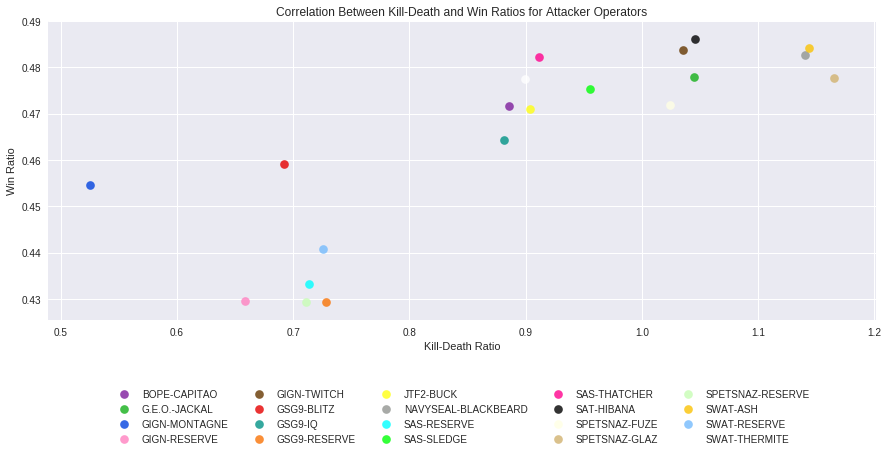

In [21]:
operators_att = operators_overall.loc[operators_overall['role'] == ('Attacker')]

colors = ["purple", "green", "blue", "pink", "brown", "red", "teal", "orange", "yellow", "grey", "cyan", "bright green", "hot pink", "black", "off white", "tan", "pale green", "goldenrod", "sky blue", "white"]
new_palette = sns.xkcd_palette(colors)

sns.lmplot(x="k/d_ratio", y="win_ratio", data=operators_att, fit_reg=False, hue='operator', legend=False, palette=new_palette, size=5, aspect=2.5, scatter_kws={"s": 75})
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
plt.title('Correlation Between Kill-Death and Win Ratios for Attacker Operators')
plt.xlabel('Kill-Death Ratio')
plt.ylabel('Win Ratio')
sns.plt.show()

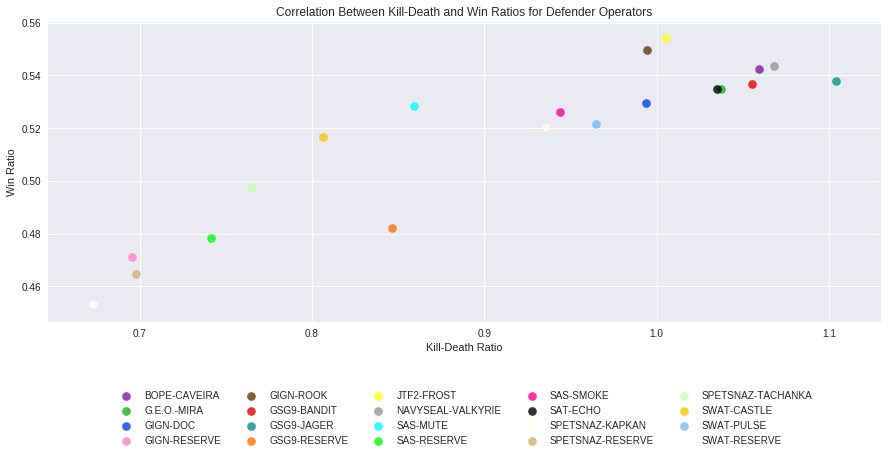

In [22]:
operators_def = operators_overall.loc[operators_overall['role'] == ('Defender')]

sns.lmplot(x="k/d_ratio", y="win_ratio", data=operators_def, fit_reg=False, hue='operator', legend=False, palette=new_palette, size=5, aspect=2.5, scatter_kws={"s": 75})
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
plt.title('Correlation Between Kill-Death and Win Ratios for Defender Operators')
plt.xlabel('Kill-Death Ratio')
plt.ylabel('Win Ratio')
sns.plt.show()